In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import linregress
from viz import AX_FACECOLOR


colors = viz.plotting_style()
lin_colors = list(colors.values())

plt.style.use('style.mpl')

In [2]:
# Read in a combined dataframe of all the coding sequence NOSC values.
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')

# Amino acid properties
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv')

# Single files per-organism of proteome level Z_C at different growth rates.
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
yeast_data = pd.read_csv('../data/proteomes/Scer/Xia_proteome_NOSC.csv')
cyano_data = pd.read_csv('../data/proteomes/Synechocystis/Zavrel_proteome_NOSC.csv')

# Unified file of the protein-level measurements.
all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_25550/4237605842.py:13: DtypeWarning: Columns (0,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')


In [3]:
mask = coli_data.condition == 'glucose_minimal'
mask = np.logical_or(mask, coli_data.condition.str.startswith('chemostat'))
coli_chemostat = coli_data[mask].copy()

# Extract the ribosome profiling data
mask = coli_data.dataset == 'li_2014'
coli_li = coli_data[mask].copy()

# extract schmidt 2016 data in chemostat_conds
coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_')]

# extract schmidt 2016 minimal media non-stress conds
mm_conds = 'glucose,fructose,galactose,glucosamine,xylose,mannose,glycerol,succinate,fumarate,pyruvate,acetate'.split(',')
mask = np.logical_and(coli_data.condition.isin(mm_conds), 
                      coli_data.dataset == 'schmidt_2016')
coli_schmidt_batch = coli_data[mask].copy()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_25550/1194820238.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_')]


LinregressResult(slope=-0.0081348076694548, intercept=-0.14210962621103426, rvalue=-0.8024423243420602, pvalue=0.00031799947608555056, stderr=0.0016777970573781005, intercept_stderr=0.0007286740419413375)


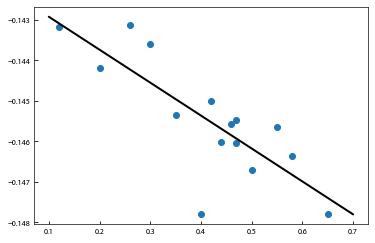

In [4]:
# Put all the plotting E. coli conditions into one dataframe.
coli_schmidt_all_conds = pd.concat([coli_schmidt_chemostat, coli_schmidt_batch])

# What is the relationship between growth rate and Z_C?
schmidt_lambda_ZCP_regression = linregress(coli_schmidt_all_conds.growth_rate_hr, coli_schmidt_all_conds.proteome_NOSC)
print(schmidt_lambda_ZCP_regression)

# plot the data
plt.plot(coli_schmidt_all_conds.growth_rate_hr, coli_schmidt_all_conds.proteome_NOSC, 'o')
# plot the regression line
xs = np.linspace(0.1, 0.7, 100)
pred_ys = schmidt_lambda_ZCP_regression.intercept + schmidt_lambda_ZCP_regression.slope * xs
plt.plot(xs, pred_ys, 'k-')
plt.show()

In [5]:
# Load biomass macromolecular composition from Bremer & Dennis 2008
biomass_percent_df = pd.read_csv('../data/physiology/BremerDennis2008_BiomassComposition_pct.csv', index_col=0)
biomass_percent_df

,protein_percent,RNA_percent,DNA_percent,doubling_time_min,doubling_time_hr,growth_rate_hr
t_100_min,60.176991,10.176991,3.362832,100.0,1.667,0.416
t_60_min,57.219251,11.764706,2.540107,60.0,1.000,0.693
t_40_min,53.153153,13.693694,2.162162,40.0,0.667,1.040
t_30_min,50.000000,16.537468,1.899225,30.0,0.500,1.386
t_24_min,46.796960,19.543974,1.867535,24.0,0.400,1.733
t_20_min,41.642229,20.918866,1.896383,20.0,0.333,2.079


LinregressResult(slope=0.07247700133385919, intercept=-0.013313442259266839, rvalue=0.9961630463335764, pvalue=2.2055075932006835e-05, stderr=0.003183692225826907, intercept_stderr=0.004307099654840597)


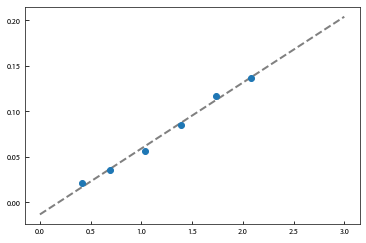

In [6]:
# Estimate ZC changes
# TODO: need to account for the slightly different carbon content of RNA, DNA and protein
cols = ['protein_percent', 'RNA_percent', 'DNA_percent']
ZCs = [-0.15, 0.9, 0.6]
inferred_ZCBs = (biomass_percent_df[cols]*ZCs/100).sum(axis=1)

reg_xs = biomass_percent_df.growth_rate_hr.values.astype(float)
reg_ys = inferred_ZCBs.values.astype(float)
lambda_ZCB_regression = linregress(reg_xs, reg_ys)
print(lambda_ZCB_regression)

# Peek at the results
lams = np.linspace(0, 3.0, 100)
plt.plot(lams, lambda_ZCB_regression.intercept + lambda_ZCB_regression.slope*lams, ls='--', color='grey')
plt.plot(biomass_percent_df.growth_rate_hr, inferred_ZCBs, 'o')

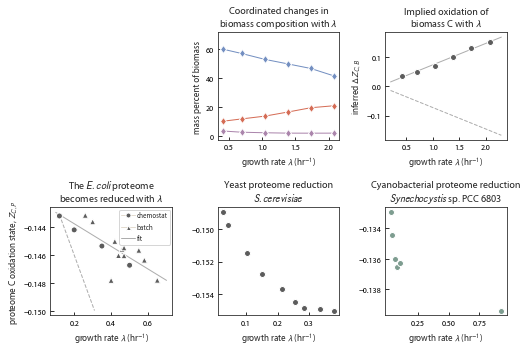

In [13]:
##### Figure 1 -- proteins expressed during faster growth are more reduced
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.24,5))
pal = sns.color_palette()
greys = sns.color_palette('Greys')

# Clear the first subplot
axs[0,0].axis('off')

# Top panels: expectations from E. coli physiology.
# Dependence of biomass fractional composition on growth rate -- 
# from Bremer and Dennis 2008 reprinted from earlier work. 
plt.sca(axs[0,1])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass percent of biomass')
plt.title('Coordinated changes in\nbiomass composition with $\lambda$')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)

plt.sca(axs[0,2])
lams = np.linspace(0.2, 2.3, 100)
# Estimate ZC changes relative to lambda = 0, i.e. the intercept of the regression
dZCB = lambda_ZCB_regression.slope*lams
plt.plot(lams, dZCB, ls='-', color=greys[2], lw=1)
plt.plot(biomass_percent_df.growth_rate_hr, inferred_ZCBs - lambda_ZCB_regression.intercept, 'o',
         color=greys[-2], markeredgecolor='w', markersize=6, lw=1)
plt.plot(lams, -dZCB, ls='--', color=greys[2], lw=1)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('inferred $\Delta Z_{C,B}$')
plt.title('Implied oxidation of\nbiomass C with $\lambda$')

# E. coli proteomes from Schmidt 2016
plt.sca(axs[1,0])

# Plot expectations from biomass composition
# We assume a diffuse mechanism where every component of the biomass is 
# as likely to be compensatorily reduced as any other component. Hence
# the factor of -0.5 applied to the slope: protein is about 1/2 of biomass.
min_lambda = coli_schmidt_chemostat.growth_rate_hr.min()
min_fit_zcp = schmidt_lambda_ZCP_regression.intercept + schmidt_lambda_ZCP_regression.slope*min_lambda
lams = np.linspace(min_lambda, 0.31, 10)
expected_ZCP = (-0.5)*lambda_ZCB_regression.slope*(lams-min_lambda) + min_fit_zcp
plt.plot(lams, expected_ZCP, ls='--', color=greys[2], lw=1, zorder=-10)

# Plot the regression line for the E. coli data
lams = np.linspace(0.1, 0.7, 10)
fit_ZCPs = schmidt_lambda_ZCP_regression.intercept + schmidt_lambda_ZCP_regression.slope*lams
plt.plot(lams, fit_ZCPs, ls='-', color=greys[2], lw=1, zorder=-10)

# Plot the data -- chemostat
sns.scatterplot(data=coli_schmidt_chemostat, x='growth_rate_hr', y='proteome_NOSC',
                style='dataset', markers='o', edgecolor='w', color=greys[-2], linewidth=1,
                legend=False)
# Plot the data -- batch
n_conds_batch = coli_schmidt_batch.condition.unique().size
sns.scatterplot(data=coli_schmidt_batch, x='growth_rate_hr', y='proteome_NOSC',
                style='dataset', markers='^', edgecolor='w', color=greys[-2], linewidth=1,
                legend=False)

plt.title('The $E. coli$ proteome\nbecomes reduced with $\lambda$')
plt.ylabel('proteome C oxidation state, $Z_{C,P}$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

legend_elements = [Line2D([0], [0], marker='o', color=AX_FACECOLOR, label='chemostat',
                          markerfacecolor=greys[-2], markeredgecolor='w',
                          linewidth=1, markersize=5),
                   Line2D([0], [0], marker='^', color=AX_FACECOLOR, label='batch',
                          markerfacecolor=greys[-2], markeredgecolor='w',
                          linewidth=1, markersize=5),
                   Line2D([0], [0], color=greys[2], label='fit', linewidth=1)]
plt.gca().legend(handles=legend_elements, loc=1,
                 handletextpad=0.2, borderaxespad=0.3, borderpad=0.3)


# S. cerevisiae proteome data from Xia 2016
plt.sca(axs[1,1])
sns.scatterplot(data=yeast_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='w', color=greys[-2], linewidth=1)
plt.title('Yeast proteome reduction\n$S. cerevisiae$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('')

# Cyanobacterial proteome data from Zavrel 2019
plt.sca(axs[1,2])
# Color by light intensity
n_intensities = cyano_data.red_light_intensity_uE_m_s.unique().size
sns.scatterplot(data=cyano_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='w', linewidth=1, color=colors['dark_green'],
                legend=False)
plt.title('Cyanobacterial proteome reduction\n$Synechocystis$ sp. PCC 6803')
plt.ylabel('')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.xticks([0.25, 0.5, 0.75])

plt.tight_layout()
plt.savefig('../output/Fig5.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

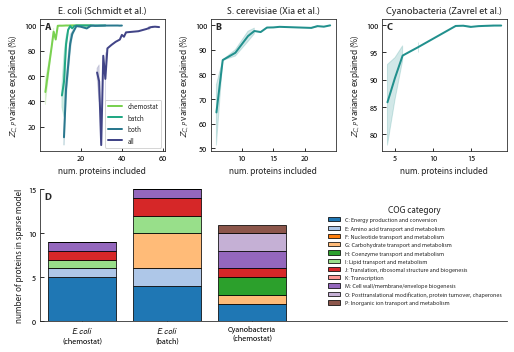

In [8]:
##### Supplementary Fig 1 -- reconstruction of proteome NOSC requires > 5 proteins with distinct functions 
# Maintext has E. coli, here we add yeast and cyanobacteria

# Load results of lasso regression analysis for varying regularization strength alpha
regression_results_df = pd.read_csv('../data/proteomes/all_lasso_regression.csv')
regression_results_df['var_explained_pct'] = 100*regression_results_df.r2
organism_dict = dict(coli='E. coli (Schmidt et al.)', yeast='S. cerevisiae (Xia et al.)', PCC6803='Cyanobacteria (Zavrel et al.)')

# Load COG category analysis at alpha = 1e-8 
long_cat_counts_df = pd.read_csv('../data/proteomes/long_lasso_regression_COG_counts_alpha=1e-08.csv')
COG_cats = pd.read_csv('../data/COG-fun-20.csv').set_index('category')

mosaic = ['A,B,C'.split(','), 'D,D,D'.split(',')]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7.24,5))

for i, org in zip('ABC', 'coli,yeast,PCC6803'.split(',')):
    plt.sca(axs[i])
    # Get the regression results for this organism, 
    # only considering cases where the model explains some variance
    mask = np.logical_and(
        regression_results_df.organism_key == org,
        regression_results_df.var_explained_pct > 0)
    sns.lineplot(data=regression_results_df[mask], x='number_nonzero', y='var_explained_pct',
                    hue='conditions_included', palette='viridis_r')
    plt.legend(title=None, loc=4)
    if org != 'coli':
        plt.legend().set_visible(False)

    plt.xlabel('num. proteins included')
    plt.ylabel('$Z_{C,P}$ variance explained (%)')
    plt.title(organism_dict[org])
    plt.text(0.04, 0.98, i, transform=plt.gca().transAxes, fontweight='bold', fontsize=10, va='top')


plt.sca(axs['D'])
pal = sns.color_palette('tab20')
j = 0
# Consider only the bacteria since the eukaryotes don't get COG categories
conds = 'coli_chemostat,coli_batch,PCC6803_chemostat'.split(',')
labels = '$E. coli$\n(chemostat),$E. coli$\n(batch),Cyanobacteria\n(chemostat)'.split(',')
n_conds = len(conds)

bottom = np.zeros(n_conds)
xs = np.arange(n_conds)
cat_order = sorted(COG_cats.index.values)
for i, cat in enumerate(cat_order):
    cat_desc = COG_cats.loc[cat].description
    masked = long_cat_counts_df[long_cat_counts_df.COG_category == cat].set_index('organism_condition')
    if masked.number_proteins.sum() == 0:
        continue

    ys = masked.loc[conds].number_proteins.values
    label = '{0}: {1}'.format(cat, cat_desc)
    plt.bar(xs, ys, bottom=bottom, color=pal[j], label=label, edgecolor='k', linewidth=0.75)
    bottom += ys
    j += 1

plt.xlim(-0.5, n_conds+2)
plt.xticks(xs, labels, ha='center')
plt.ylabel('number of proteins in sparse model')
plt.yticks(np.arange(0, 15.1, 5))
plt.text(0.01, 0.98, 'D', transform=plt.gca().transAxes, fontweight='bold', fontsize=10, va='top')

l = plt.legend(loc='center right', title='COG category', fontsize=6, frameon=False)
plt.setp(l.get_title(), fontsize=9)
sns.despine(ax=plt.gca())

plt.tight_layout()
plt.savefig('../output/Fig5S1.png', facecolor='w', dpi=300)
plt.show()

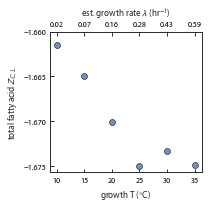

In [9]:
# Read lipid redox data from Marr 1962 -- they measured only FA composition
# not total FA content as a fraction of dry weight or C. 
total_lipids_marr = pd.read_csv('../data/lipids/Coli/Marr1962_total_lipids_NOSC.csv')

# Model for T-dependent growth rate of E. coli in a similar glucose
# minimal medium to Marr. See Table 1 of Gill 1985 for fit parameters 
b = 0.0262
c = 0.298
Tmax = 47.3
Tmin = 4.9
temps = np.arange(10, 36, 5)
RHS = b*(temps-Tmin)*(1-np.exp(c*(temps-Tmax)))
pred_mu = np.power(RHS, 2)

# Plot T on the primary X axis, inferred growth rate on the top X axis
plt.figure(figsize=(3,3))

mask = total_lipids_marr.experiment == 'temp'
# The fit from Gill 1985 has a max around 40 C
mask = np.logical_and(mask, total_lipids_marr.temp_C < 36)
plt.scatter(total_lipids_marr[mask].temp_C, total_lipids_marr[mask].lipid_NOSC,
            label='Marr 1962', edgecolor='k', lw=0.5, color=colors['blue'])

plt.xlabel('growth T ($\degree$C)')
plt.ylabel('total fatty acid $Z_{C,L}$')
xlim = plt.xlim()
plt.xticks(temps)
plt.yticks(-np.arange(1.66, 1.676, 0.005))

plt.twiny()

plt.xticks(temps, np.round(pred_mu, 2))
plt.xlim(xlim)
plt.xlabel('est. growth rate $\lambda$ (hr$^{-1}$)')

plt.tight_layout()
plt.savefig('../output/Fig5S3_lipids.png', facecolor='w', dpi=300)
plt.show()

In [10]:
# Reading the monte-carlo samples of proteome NOSC per-genome.
unweighted_nosc_est_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC_unweighted_monte_carlo_samples.csv')

# These are "weighted" i.e. allowing for 5 order of variation in expression.
weighted_nosc_est_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC_weighted_monte_carlo_samples.csv')

coli mean: -0.15 +/- 0.00
yeast mean: -0.15 +/- 0.00
PCC6803 mean: -0.14 +/- 0.00
coli mean: -0.15 +/- 0.00
yeast mean: -0.15 +/- 0.00
PCC6803 mean: -0.14 +/- 0.00


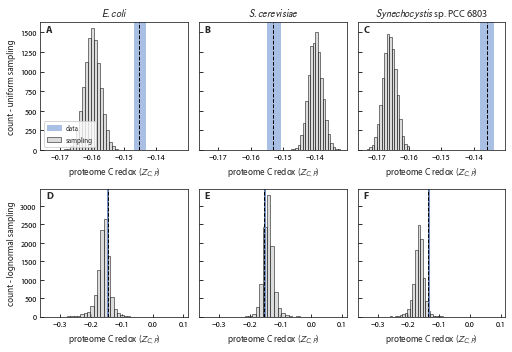

In [11]:
##### Supplementary Fig -- coding sequences are not a good predictor of $Z_{C,P}$
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.22,5), sharey='row', sharex='row')
flat_axs = axs.flatten()

coli_vals = coli_data[coli_data.proteome_NOSC.notnull()].proteome_NOSC.values
yeast_vals = yeast_data[yeast_data.proteome_NOSC.notnull()].proteome_NOSC.values
cyano_vals = cyano_data[cyano_data.proteome_NOSC.notnull()].proteome_NOSC.values
means_dict = dict(coli=coli_vals.mean(), yeast=yeast_vals.mean(), PCC6803=cyano_vals.mean())
stds_dict = dict(coli=coli_vals.std(), yeast=yeast_vals.std(), PCC6803=cyano_vals.std())

# Top row compares unweighted sampling to measurements of proteome NOSC
order = 'coli,yeast,PCC6803'.split(',')
labels = dict(coli='$E. coli$', yeast='$S. cerevisiae$', PCC6803='$Synechocystis$ sp. PCC 6803')
for i, org in enumerate(order):
    plt.sca(axs[0, i])
    samples = unweighted_nosc_est_df[unweighted_nosc_est_df.organism == org]
    sns.histplot(data=samples, x='NOSC', bins=20, color=greys[1], edgecolor='k', linewidth=0.5, label='sampling')
    plt.title(labels[org])
    plt.xlabel('proteome C redox ($Z_{C,P}$)')

    print('{0} mean: {1:.2f} +/- {2:.2f}'.format(org, means_dict[org], stds_dict[org]))
    plt.axvline(means_dict[org], color='k', ls='--', lw=1)
    plt.axvspan(means_dict[org]-stds_dict[org], means_dict[org]+stds_dict[org],
                color=colors['light_blue'], label='data')
    plt.legend().set_visible(False)

for i, org in enumerate(order):
    plt.sca(axs[1, i])
    samples = weighted_nosc_est_df[weighted_nosc_est_df.organism == org]
    sns.histplot(data=samples, x='NOSC', bins=30, color=greys[1], linewidth=0.5, edgecolor='k')
    plt.xlabel('proteome C redox ($Z_{C,P}$)')

    print('{0} mean: {1:.2f} +/- {2:.2f}'.format(org, means_dict[org], stds_dict[org]))
    plt.axvline(means_dict[org], color='k', ls='--', lw=1)
    plt.axvspan(means_dict[org]-stds_dict[org], means_dict[org]+stds_dict[org],
                color=colors['blue'])

panel_labels = 'ABCDEF'
for label, ax in zip('ABCDEF', flat_axs):
    plt.sca(ax)
    plt.text(0.04, 0.98, label, transform=plt.gca().transAxes,
             fontweight='bold', fontsize=10, va='top')
    
plt.sca(axs[0,0])
plt.ylabel('count - uniform sampling')
plt.legend(loc=3, framealpha=0.8).set_visible(True)
plt.sca(axs[1,0])
plt.ylabel('count - lognormal sampling')

plt.tight_layout()
plt.savefig('../output/Fig5S2_CDS_not_representative.png', facecolor='w', dpi=300)
plt.show()
